# [95-865] Unstructured Data Analysis: Final Exam Q2

Name:  
Andrew ID:

Before getting started: 
* Put the attached file __*cnn_model.h5*__ in the same directory as this notebook.
* You need 'h5py' package to load the model. Use command `conda install -c conda-forge h5py` to install.

# Q2: Bottleneck layer [Total: 75 points]

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. We will refer to the layer before the classifier in the neural net as the bottleneck layer. 

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images.

In [1]:
from keras.datasets import fashion_mnist
from keras.models import load_model
from keras.models import Model
import keras
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using Theano backend.


### Data exploration

Load the Fashion MNIST dataset and check how it looks like.

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


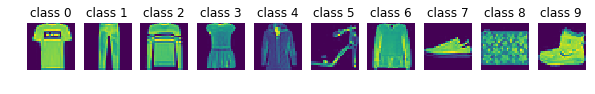

In [2]:
# load the MNIST data set, which already splits into train and test sets for us
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
_, x_img, y_img = x_train.shape
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# See how the images look like
labels = np.unique(y_train)
f, axarr = plt.subplots(1, 10, figsize=(10, 10))
for l in labels:
    idx = np.argwhere(y_train==l)[0][0]
    img = x_train[idx]
    axarr[l].imshow(img)
    axarr[l].set_title('class '+str(l))
    axarr[l].axis('off')

### Loading pre-trained CNN

Before loading the pre-trained model, you should reshape the data to make it fit the Keras structure.

In [3]:
num_classes = 10

# reshape the data into a 4D tensor: (sample_number, x_img_size, y_img_size, num_channels)
# because the fashion MNIST is greyscale, we only have a single channel
x_train = x_train.reshape(x_train.shape[0], x_img, y_img, 1)
x_test = x_test.reshape(x_test.shape[0], x_img, y_img, 1)

# convert the data to the right type
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# convert class vectors to binary class matrices - 
# this should be used for Keras functions
y_train_c = keras.utils.to_categorical(y_train, num_classes)
y_test_c = keras.utils.to_categorical(y_test, num_classes)

<h3><font color='blue'>(a) [5 points]</font></h3>

Select train and test data that belong to classes 2 (corresponding to pullovers) and 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save  the variables with the same names as before (`x_train`, `x_test`, `y_train`, `y_test`, `y_train_c`, `y_test_c`). From now on, we are only dealing with the images that are in classes 2 (pullovers) and 6 (shirts).

In [4]:
# write your code here
##########################################################################
idx = np.where((y_train==2) | (y_train==6))[0]
x_train = x_train[idx]; y_train = y_train[idx]; y_train_c = y_train_c[idx]
idx = np.where((y_test==2) | (y_test==6))[0]
x_test = x_test[idx]; y_test = y_test[idx]; y_test_c = y_test_c[idx]
##########################################################################

In [5]:
print(x_train.shape, y_train.shape, y_train_c.shape)
print(x_test.shape, y_test.shape, y_test_c.shape)

(12000, 28, 28, 1) (12000,) (12000, 10)
(2000, 28, 28, 1) (2000,) (2000, 10)


<h3><font color='blue'>(b) [5 points]</font></h3>

Reduce the size of train dataset for later use. Randomly subsample 100 samples from `x_train`. Shrink the size of `y_train` accordingly. Again, name those variables as before (`x_train`, `y_train`).

In [6]:
# write your code here
##########################################################################
np.random.seed(124)
random_sample = np.random.permutation(x_train.shape[0])[:100]
x_train = x_train[random_sample]
y_train = y_train[random_sample]
##########################################################################

We are ready to load the pre-trained model. The pre-trained CNN contains a dense layer with output size 20 which is regarded as a bottleneck layer. Let's call the output vector of this layer the bottleneck feature vector. Furthermore, this model was pre-trained using the entire training dataset which consists 60,000 samples. While training with mini-batch scheme, it only iterated for 5 epochs, so the model might not show the highest performance.

In [7]:
# load the pre-trained CNN
model = load_model('./cnn_model.h5')
print('<Summary of the pre-trained CNN>')
model.summary()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)
print('<Summary of the pre-trained CNN up to the bottleneck layer>')
intermediate_layer_model.summary()

<Summary of the pre-trained CNN>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               460900    
_________________________________________________________________
bottleneck (Dense)           (None, 20)                2020      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 463,962
Trainable params: 463,962
Non-trainable params: 0
_____________________________________

<h3><font color='blue'>(c) [5 points]</font></h3>

Extract bottleneck feature vectors of the train and test data from the intermediate model (_hint_: the neural net contained in `intermediate_layer_model` has an output that is precisely the bottleneck feature vector, so to figure out what the bottleneck feature vector is for any data point, you would simply use the `predict` function of `intermediate_layer_model`). Print the shapes of bottleneck features extracted from train and test data by using the `.shape` command.

In [8]:
# write your code here
##########################################################################
x_train_bottleneck = intermediate_layer_model.predict(x_train)
x_test_bottleneck = intermediate_layer_model.predict(x_test)
print('x_train_bottleneck shape:',x_train_bottleneck.shape)
print('x_test_bottleneck shape:',x_test_bottleneck.shape)
##########################################################################

x_train_bottleneck shape: (100, 20)
x_test_bottleneck shape: (2000, 20)


<h3><font color='blue'>(d) Visualization [10 points]</font></h3>

Visualize two different types of features using t-SNE. Use **784 (=28$\times$28) dimensional raw features** and **20 dimensional bottleneck features** from **test data** (one plot each). Set `n_components=2, verbose=1, perplexity=40` for `TSNE` from scikit-learn. Plot the two classes with different colors.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.032s...
[t-SNE] Computed neighbors for 2000 samples in 5.524s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.918874
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.232498
[t-SNE] Error after 1000 iterations: 1.261521
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.713100
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.709557
[t-SNE] Error after 1000 iterations: 1.172504


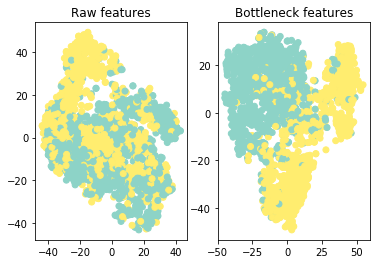

In [9]:
# write your code here
##########################################################################
x_train_flat = x_train.reshape(x_train.shape[0],-1)
x_test_flat = x_test.reshape(x_test.shape[0],-1)

from sklearn.manifold import TSNE
plt.subplot(121)
plt.title('Raw features')
tsne = TSNE(n_components=2, verbose=1, perplexity=40)
feature_vectors_tsne2d = tsne.fit_transform(x_test_flat)
plt.scatter(feature_vectors_tsne2d[:, 0], 
            feature_vectors_tsne2d[:, 1], 
            c=y_test, cmap='Set3')
plt.subplot(122)
plt.title('Bottleneck features')
tsne = TSNE(n_components=2, verbose=1, perplexity=40)
feature_vectors_tsne2d = tsne.fit_transform(x_test_bottleneck)
plt.scatter(feature_vectors_tsne2d[:, 0], 
            feature_vectors_tsne2d[:, 1], 
            c=y_test, cmap='Set3')
##########################################################################

<h3><font color='blue'>(e) Test accuracy comparison [20 points]</font></h3>

Train **1-NN**, **random forest** and **linear SVM** classifiers with **784 (=28$\times$28) raw features** and **20 bottleneck features** from **train data** repectively. That means you should train 6 models in total. Test each model with corresponding **test dataset** and print the test accuracy. For model training, use default parameters if not specified. 
Also, compute and print the test accuracy of **pretrained CNN** (`model`) by using **test data**. You may think of this task as filling in the blanks on the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |                     | this cell stays empty|
| 1-NN             |                     |                      |
| Random forest    |                     |                      |
| Linear SVM       |                     |                      |

In [10]:
# write your code here
##########################################################################
def print_result(name,r_acc,b_acc):
    print(name.ljust(15), str(r_acc).ljust(15), str(b_acc).ljust(15))
    
print_result('','Raw features','Bottleneck features')

# Evaluate Pretrained CNN accuracy on x_test (raw features)
(_, cnn_accuracy) = model.evaluate(x_test, y_test_c, verbose=0)
print_result('Pretrained CNN',cnn_accuracy,'')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import copy

names = ['1-NN','Random Forest','Linear SVM']
clfs = [KNeighborsClassifier(1), RandomForestClassifier(), SVC(kernel='linear')]
for name, clf_r, clf_b in zip(names,clfs,copy.deepcopy(clfs)):
# train models with raw features and bottleneck features repectively
    # train and test with raw features
    clf_r.fit(x_train_flat, y_train)
    r_accuracy = clf_r.score(x_test_flat, y_test)
    # train and test with bottleneck features
    clf_b.fit(x_train_bottleneck, y_train)
    b_accuracy = clf_b.score(x_test_bottleneck, y_test)
    
    print_result(name,r_accuracy,b_accuracy)
##########################################################################

                Raw features    Bottleneck features
Pretrained CNN  0.7675                         
1-NN            0.692           0.8475         
Random Forest   0.729           0.873          
Linear SVM      0.7375          0.882          


<h3><font color="blue">(f) [5 points]</font></h3>

Among the seven models above, which model performed the best? Which model showed the lowest accuracy? In average, using which type of feature (raw / bottleneck) performed better? Explain the reason using the visualization result.

Write your answer here: 

Linear SVM trained with bottleneck features showed the highest accuracy. 1-NN trained with raw features had the lowest accuracy. In general, models trained with bottleneck features, which has only 20 features, performed better. This is becuase, as shown in the visualization result, the bottleneck features seem to separate two classes of images better than raw features. 

<h3><font color='blue'>(g) ROC curve with varying k in k-NN [20 points]</font></h3>

Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of **train** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

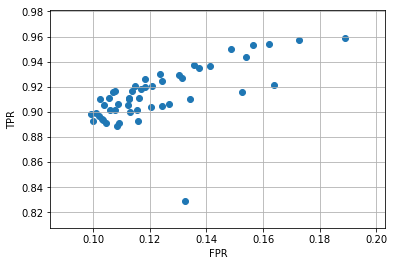

In [11]:
# write your code here
##########################################################################
from sklearn.metrics import confusion_matrix

ks = range(50)
fprs, tprs = [], []

for k in ks:
    clf = KNeighborsClassifier(k+1)
    clf.fit(x_train_bottleneck, y_train)
    y_preds = clf.predict(x_test_bottleneck)
    tn, fp, fn, tp = confusion_matrix(y_preds, y_test).ravel()
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    fprs.append(fpr)
    tprs.append(tpr)

plt.scatter(fprs, tprs)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
##########################################################################

<h3><font color="blue">(h) [5 points]</font></h3>

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. Explain how you would choose $k$ for $k$-NN classification such that you have high true positive rate but don't have more than a 12.5% false positive rate.

Write your answer here:

Let's say we want to retain FPR less than 0.125 and achieve TPR as high as possible. Therefore we should select k as the one that has FPR 0.125 and TPR 0.93 based on the plot above.